In [1]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from ekf_vindy.plotting import plotter
from ekf_vindy.vindy.utils import add_lognormal_noise
from ekf_vindy.vindy import torch_config
from scipy.integrate import odeint

seed = 29

# Setup torch device and dtype

np.random.seed(seed)

/home/carlos/.cache/pypoetry/virtualenvs/vindy-MoRRIXoN-py3.11/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


LaTeX is installed. Using LaTeX for rendering.


In [2]:
torch_config.setup_device_and_type()

PyTorch device set to cpu and dtype set to torch.float32.


# Roessler ODE with VINDy

We will use the varional version of SINDy to learn the following dynamical system:

$$
\begin{align}
\dot{z}_0 &= -z_1 - z_2, \\
\dot{z}_1 &= z_0 + a z_1, \\
\dot{z}_2 &= b + z_2 (z_0 - c),
\end{align}
$$

where $ a = 0.2, b = 0.2, c = 5.7$. Notice that in the first equation we will learn the coefficients $1$ as well. Let's define the vector field and generate training data.

In [3]:
def roessler(x, t, params):
    a = params['a']
    b = params['b']
    c = params['c']
    
    x, y, z =  x[0], x[1], x[2]
    return [-y - z, x + a * y, b + z * (x - c)]

Let's generate trajectories and add some noise to them.

In [4]:
params = {
    'a' : 0.2,
    'b' : 0.2,
    'c' : 5.7}

dt = 0.012 # Roughly what they use in VENI-VINDy-VICI
mean_ic = np.array([-5, -5, 0])
std = 1
n_train = 30
sigma_noise = 0.01
x_0 = np.random.randn(n_train, 3) * std + mean_ic
time_instances = np.arange(0, 24, dt)
x_train = []



for i in range(n_train):
    sol = odeint(roessler, x_0[i, :], time_instances, args=(params,))
    x_train.append(sol)

x_train = [add_lognormal_noise(x, sigma_noise)[0] for x in x_train]

model = ps.SINDy(feature_names=['u1', 'u2', 'u3'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))
model.fit(x_train, t=0.012, multiple_trajectories=True)
model.print()

x_train_np = np.stack(x_train, axis=0)     # shape: (n_train, T, 2)
x_train = torch.from_numpy(x_train_np).to(device = torch_config.device, dtype = torch_config.dtype)
x_train.shape


(u1)' = -1.000 u2 + -1.000 u3
(u2)' = 1.000 u1 + 0.200 u2
(u3)' = 0.201 1 + -5.695 u3 + 0.999 u1 u3


torch.Size([30, 2000, 3])

Compute derivatives by hand

In [5]:
dt = torch.tensor(dt, device=torch_config.device, dtype=torch_config.dtype)
# central
dxdt_mid = (x_train[:, 2:, :] - x_train[:, :-2, :]) / (2 * dt)

# forward difference for first point
dxdt_0 = (x_train[:, 1:2, :] - x_train[:, 0:1, :]) / dt

# backward difference for last point
dxdt_T = (x_train[:, -1:, :] - x_train[:, -2:-1, :]) / dt

# concatenate to get shape (N, T, 2)
dxdt = torch.cat([dxdt_0, dxdt_mid, dxdt_T], dim=1)

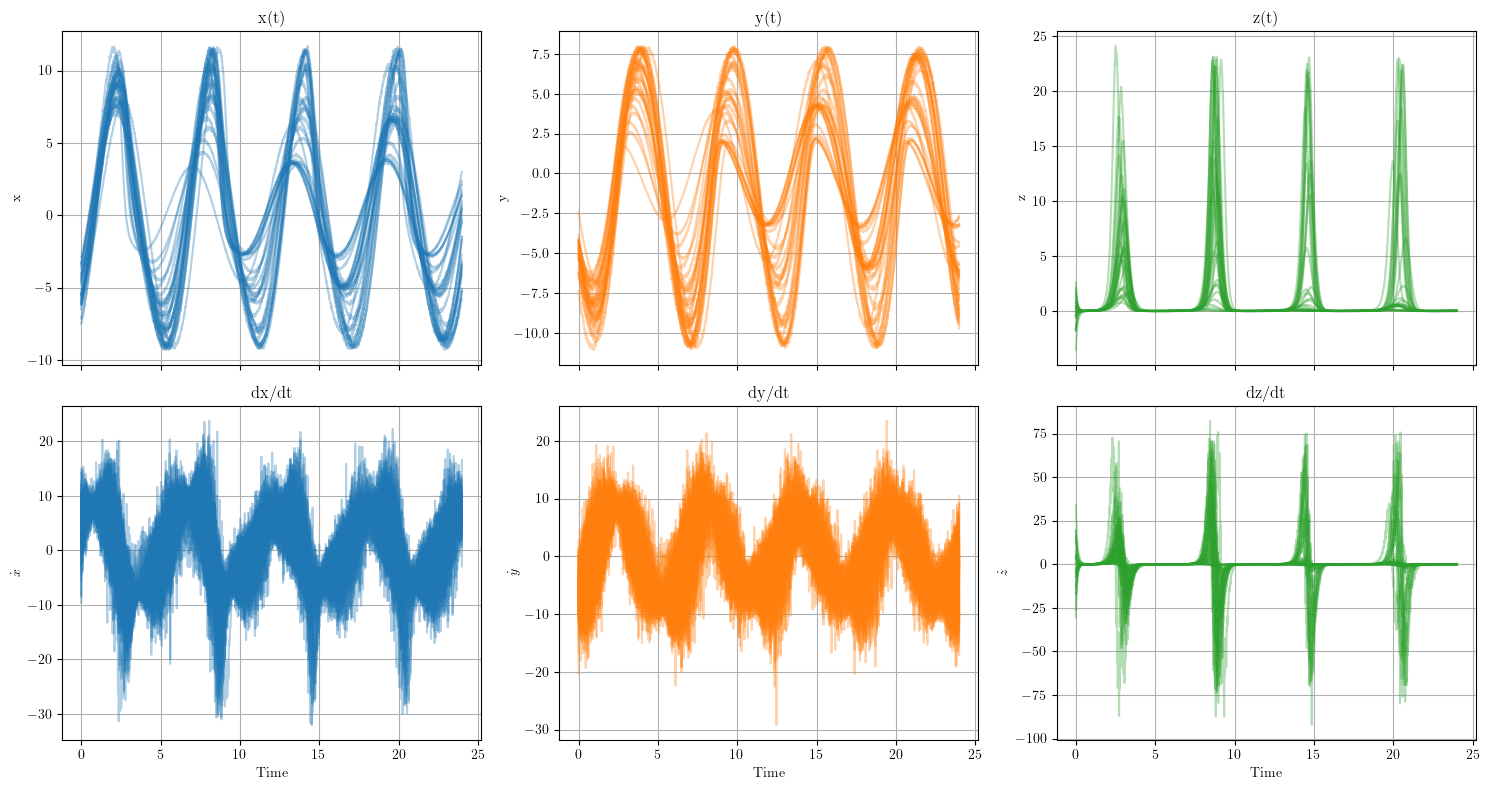

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

state_colors = ['tab:blue', 'tab:orange', 'tab:green']
# deriv_colors = ['tab:red', 'tab:purple', 'tab:brown']
names = ['x', 'y', 'z']

# -------- ROW 1: STATES x, y, z --------
for dim in range(3):
    ax = axes[0, dim]
    for i in range(n_train):
        ax.plot(
            time_instances,
            x_train[i, :, dim].cpu().numpy(),
            alpha=0.35,
            color=state_colors[dim]
        )
    ax.set_title(f"{names[dim]}(t)")
    ax.set_ylabel(names[dim])
    ax.grid(True)

# -------- ROW 2: DERIVATIVES xdot, ydot, zdot --------
for dim in range(3):
    ax = axes[1, dim]
    for i in range(n_train):
        ax.plot(
            time_instances,
            dxdt[i, :, dim].cpu().numpy(),
            alpha=0.35,
            color=state_colors[dim]
        )
    ax.set_title(f"d{names[dim]}/dt")
    ax.set_ylabel(rf"$\dot{{{names[dim]}}}$")  # mathtext
    ax.set_xlabel("Time")
    ax.grid(True)

plt.tight_layout()
plt.show()

Now we set up VINDy and train...

In [40]:
from ekf_vindy.vindy.layers.vindy_layer import VINDyLayer
from ekf_vindy.vindy.training_loops import train_vindy

N, T, n = x_train.shape

z_train = x_train.reshape(N * T, n)
dzdt_train = dxdt.reshape(N * T, n)

vindy_layer = VINDyLayer(latent_dim=3,
                         n_parameters=0,
                         poly_order=2,
                         parameter_names=None,
                         init_scheme_loc='uniform',
                         init_scheme_log_scale='uniform',
                         prior_loc=0.0,
                         prior_scale=1.0)

train_vindy(
    vindy_layer,
    z_train,
    dzdt_train,
    n_epochs = 250,
    lr = 1e-3,
    batch_size=256,
    huber_weight= 1.0,
    kl_weight= 1e-3,
)

[Epoch 0 | Batch 0] loss=4.8465e+01 huber=4.8455e+01 KL=9.6667e+00
[Epoch 0 | Batch 1] loss=5.6803e+01 huber=5.6793e+01 KL=9.6549e+00
[Epoch 0 | Batch 2] loss=9.0583e+01 huber=9.0573e+01 KL=9.6466e+00
[Epoch 0 | Batch 3] loss=6.1484e+01 huber=6.1475e+01 KL=9.6388e+00
[Epoch 0 | Batch 4] loss=8.7190e+01 huber=8.7180e+01 KL=9.6322e+00
[Epoch 0 | Batch 5] loss=6.9738e+01 huber=6.9728e+01 KL=9.6253e+00
[Epoch 0 | Batch 6] loss=8.8112e+01 huber=8.8102e+01 KL=9.6189e+00
[Epoch 0 | Batch 7] loss=6.8911e+01 huber=6.8901e+01 KL=9.6106e+00
[Epoch 0 | Batch 8] loss=5.1489e+01 huber=5.1479e+01 KL=9.6031e+00
[Epoch 0 | Batch 9] loss=9.8762e+01 huber=9.8752e+01 KL=9.5961e+00
[Epoch 0 | Batch 10] loss=7.6075e+01 huber=7.6065e+01 KL=9.5887e+00
[Epoch 0 | Batch 11] loss=8.6045e+01 huber=8.6035e+01 KL=9.5808e+00
[Epoch 0 | Batch 12] loss=1.1355e+02 huber=1.1354e+02 KL=9.5727e+00
[Epoch 0 | Batch 13] loss=1.3021e+02 huber=1.3020e+02 KL=9.5641e+00
[Epoch 0 | Batch 14] loss=6.5045e+01 huber=6.5035e+01 KL=9

VINDyLayer()

In [37]:
print(vindy_layer.big_xi_log_scales)
print('---------------------------------')
print(vindy_layer.big_xi)

Parameter containing:
tensor([[-2.8380, -2.8887, -3.1888],
        [-4.1493, -4.5390, -4.8456],
        [-4.5274, -4.0799, -4.8629],
        [-3.7330, -4.0636, -3.2999],
        [-6.0055, -6.5846, -6.7999],
        [-5.6500, -5.6812, -6.3783],
        [-5.3100, -5.9353, -5.2195],
        [-6.5077, -5.9499, -6.8981],
        [-4.6957, -4.6645, -4.3360],
        [-6.4156, -6.7828, -5.9078]], requires_grad=True)
---------------------------------
Parameter containing:
tensor([[ 4.2753e-03,  3.6645e-05,  1.8475e-01],
        [-6.0762e-03,  1.0011e+00, -3.4230e-03],
        [-9.9874e-01,  2.0023e-01,  4.0189e-03],
        [-9.7165e-01,  3.9647e-03, -5.6545e+00],
        [-1.6461e-04, -9.3374e-04,  1.1563e-04],
        [ 4.5227e-04,  5.9425e-05,  1.5111e-03],
        [ 2.6703e-04, -4.4498e-04,  9.9411e-01],
        [ 1.4056e-03, -2.3152e-03,  1.0356e-03],
        [-4.4972e-03, -3.0700e-03, -9.2276e-03],
        [-5.5598e-04,  1.3548e-04, -2.0513e-03]], requires_grad=True)


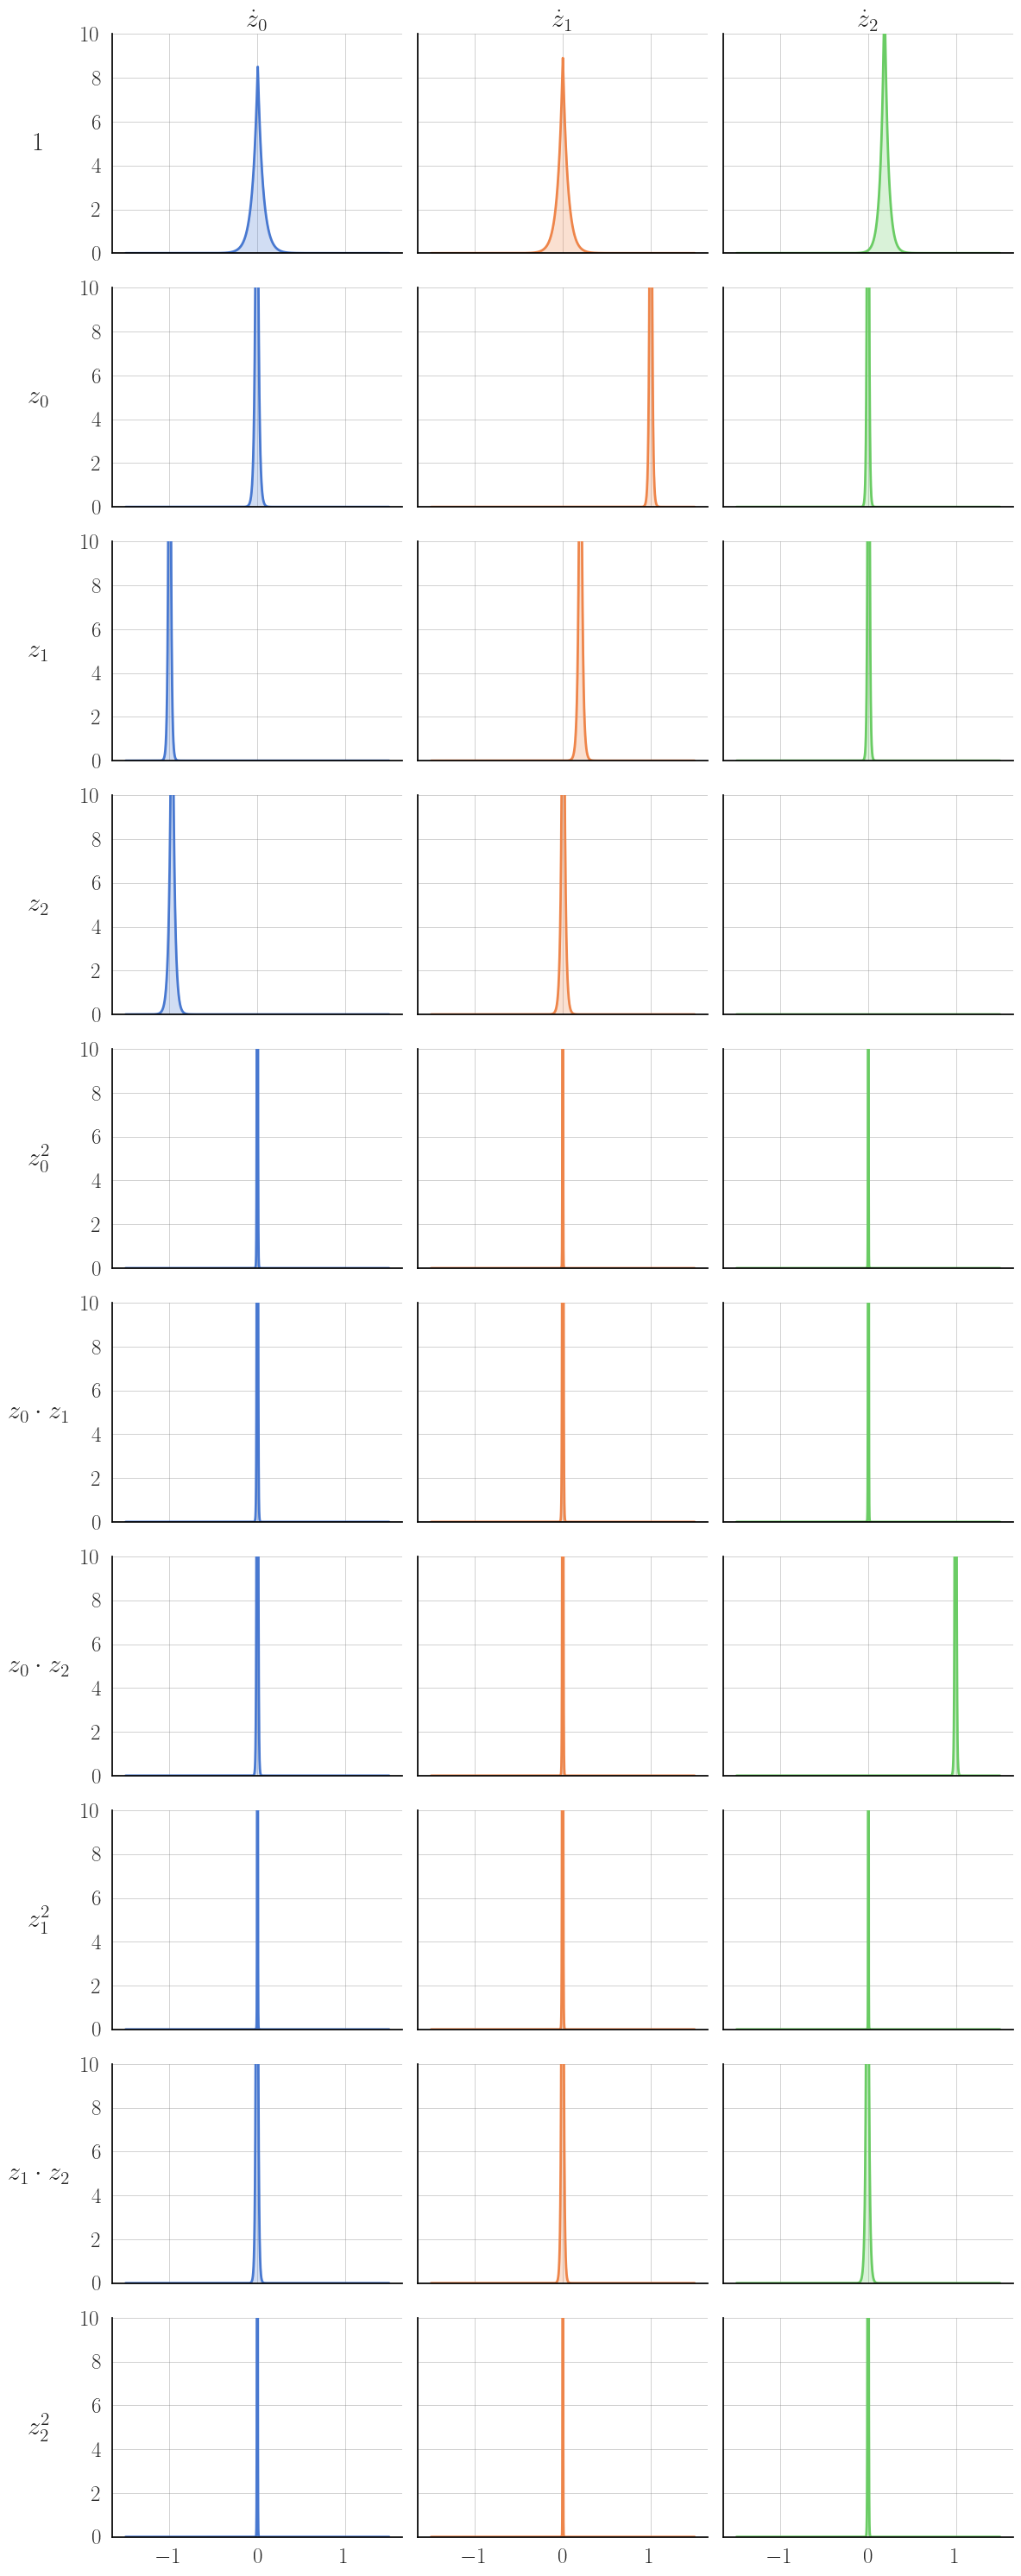

In [39]:
from ekf_vindy.plotting.plotter import plot_pdf
from sympy import symbols

dot_symbols = [symbols(f'zdot_{i}') for i in range(3)] 
fig, axes = plot_pdf(
    *vindy_layer.big_xi_distribution.evaluate_pdf(x_range = 1.5),
    ylim=(0, 10.0),
    palette="muted",
    label_size="large",
    dim_labels=dot_symbols,
    batch_labels=vindy_layer.library_symbols
)
plt.show()